In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])   # Coefficient oposite signs to those we wish to simulate

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

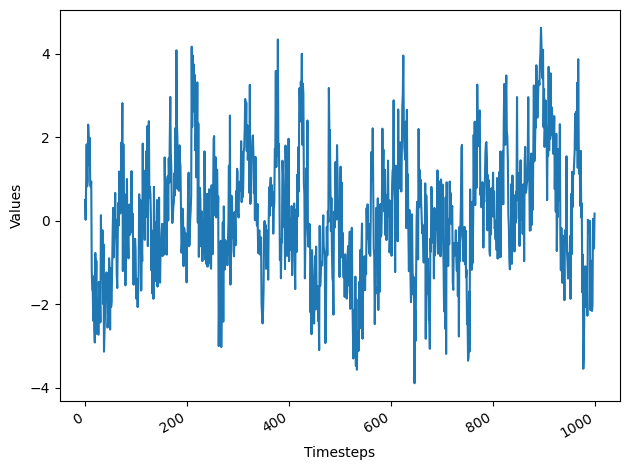

In [3]:
fig, ax = plt.subplots()

ax.plot(AR2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(AR2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows stationarity

ADF Statistic: -7.566606021416905
p-value: 2.9145161293763083e-11


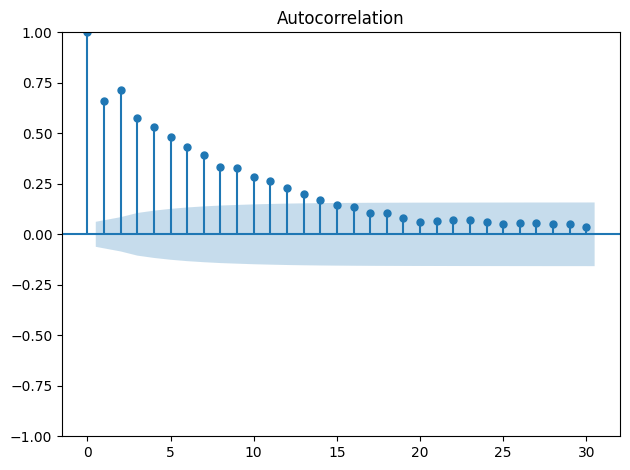

In [5]:
plot_acf(AR2_process, lags=30)

plt.tight_layout()

ACF is slowly decaying

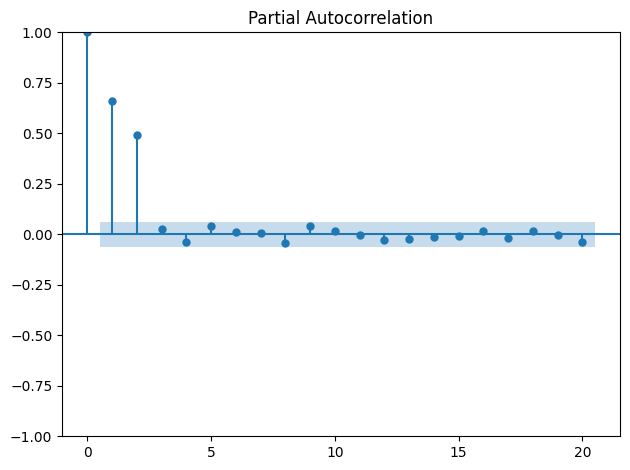

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.tight_layout()

No significant coefficients after lag 2

We could use a AR(2) model

In [7]:
df = pd.DataFrame({'Values': AR2_process})

train = df[:800]
test = df[800:]

print(len(train))
print(len(test))

800
200


In [8]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))      #  The order specifies an AR(3) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [9]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,Values,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.221317
801,0.095529,-0.049737,0.461912,0.290105
802,0.704340,-0.048056,0.095529,0.587501
803,-0.182079,-0.048056,0.095529,0.256042
804,-0.142412,-0.047287,-0.182079,0.280298


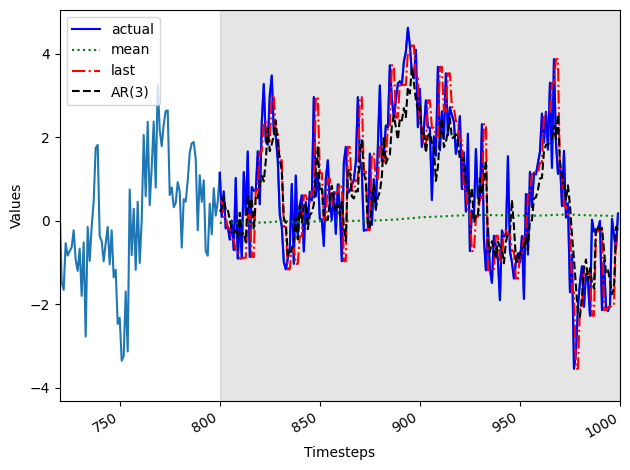

In [10]:
fig, ax = plt.subplots()

ax.plot(df['Values'])
ax.plot(test['Values'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(720, 1000)

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Values'], test['pred_mean'])
mse_last = mean_squared_error(test['Values'], test['pred_last_value'])
mse_AR = mean_squared_error(test['Values'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9691013344818512


My champion model is AR(2)

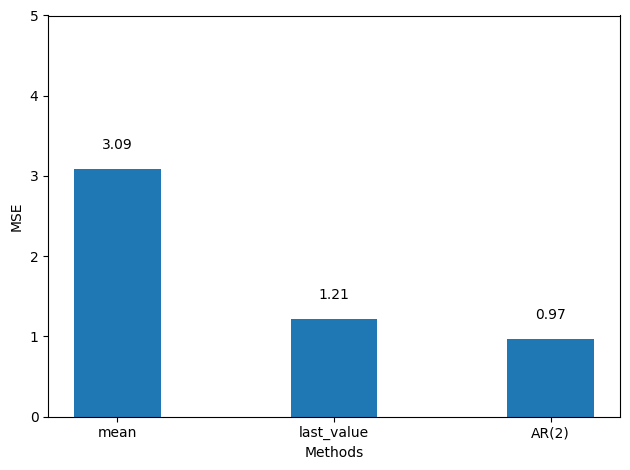

In [12]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()